## Import necessary libraries

In [62]:
# hellloooooooo
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

## 📩 Read CSV

In [63]:
df = pd.read_csv('heart.csv')                                           # đọc dữ liệu từ file csv
df.head()                                                               # hiển thị 5 dòng đầu tiên của data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## 📜 Dataset Information
- **Age**: age of the patient
- **Sex**: sex of the patient
    - M: Male
    - F: Female
- **ChestPainType**: chest pain type
    - TA: Typical Angina
    - ATA: Atypical Angina
    - NAP: Non-Anginal Pain
    - ASY: Asymptomatic
- **RestingBP**: resting blood pressure (mm/Hg)
- **Cholesterol**: serum cholesterol (mm/dl)
- **FastingBS**: fasting blood sugar 
    - 1: if FastingBS > 120 mg/dl
    - 0: otherwise
- **RestingECG**: resting electrocardiogram results
    - Normal: Normal
    - ST: having ST-T wave abnormality [T wave inversions and/or ST elevation or depression of > 0.05 mV]
    - LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria
- **MaxHR**: maximum heart rate achieved [Numeric value between 60 and 202]
- **ExerciseAngina**: exercise-induced angina [Y: Yes, N: No]
- **Oldpeak**: oldpeak = ST [Numeric value measured in depression]
- **ST_Slope**: the slope of the peak exercise ST segment
    - Up: upsloping
    - Flat: flat
    - Down: downsloping
- **HeartDisease**: output class 
    - 1: heart disease
    - 0: Normal

## 📊 EDA

From the above information, we can categorize values in the dataset into these categories:

In [64]:
continuos_f = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]                           # Kiểu số
categorical_f = ["ChestPainType", "RestingECG", "ST_Slope"]                                     # Kiểu chữ
binaries_f = ["Sex", "FastingBS", "ExerciseAngina"]                                             # Kiểu nhị phân (true false or 0 1)

<Figure size 800x550 with 0 Axes>

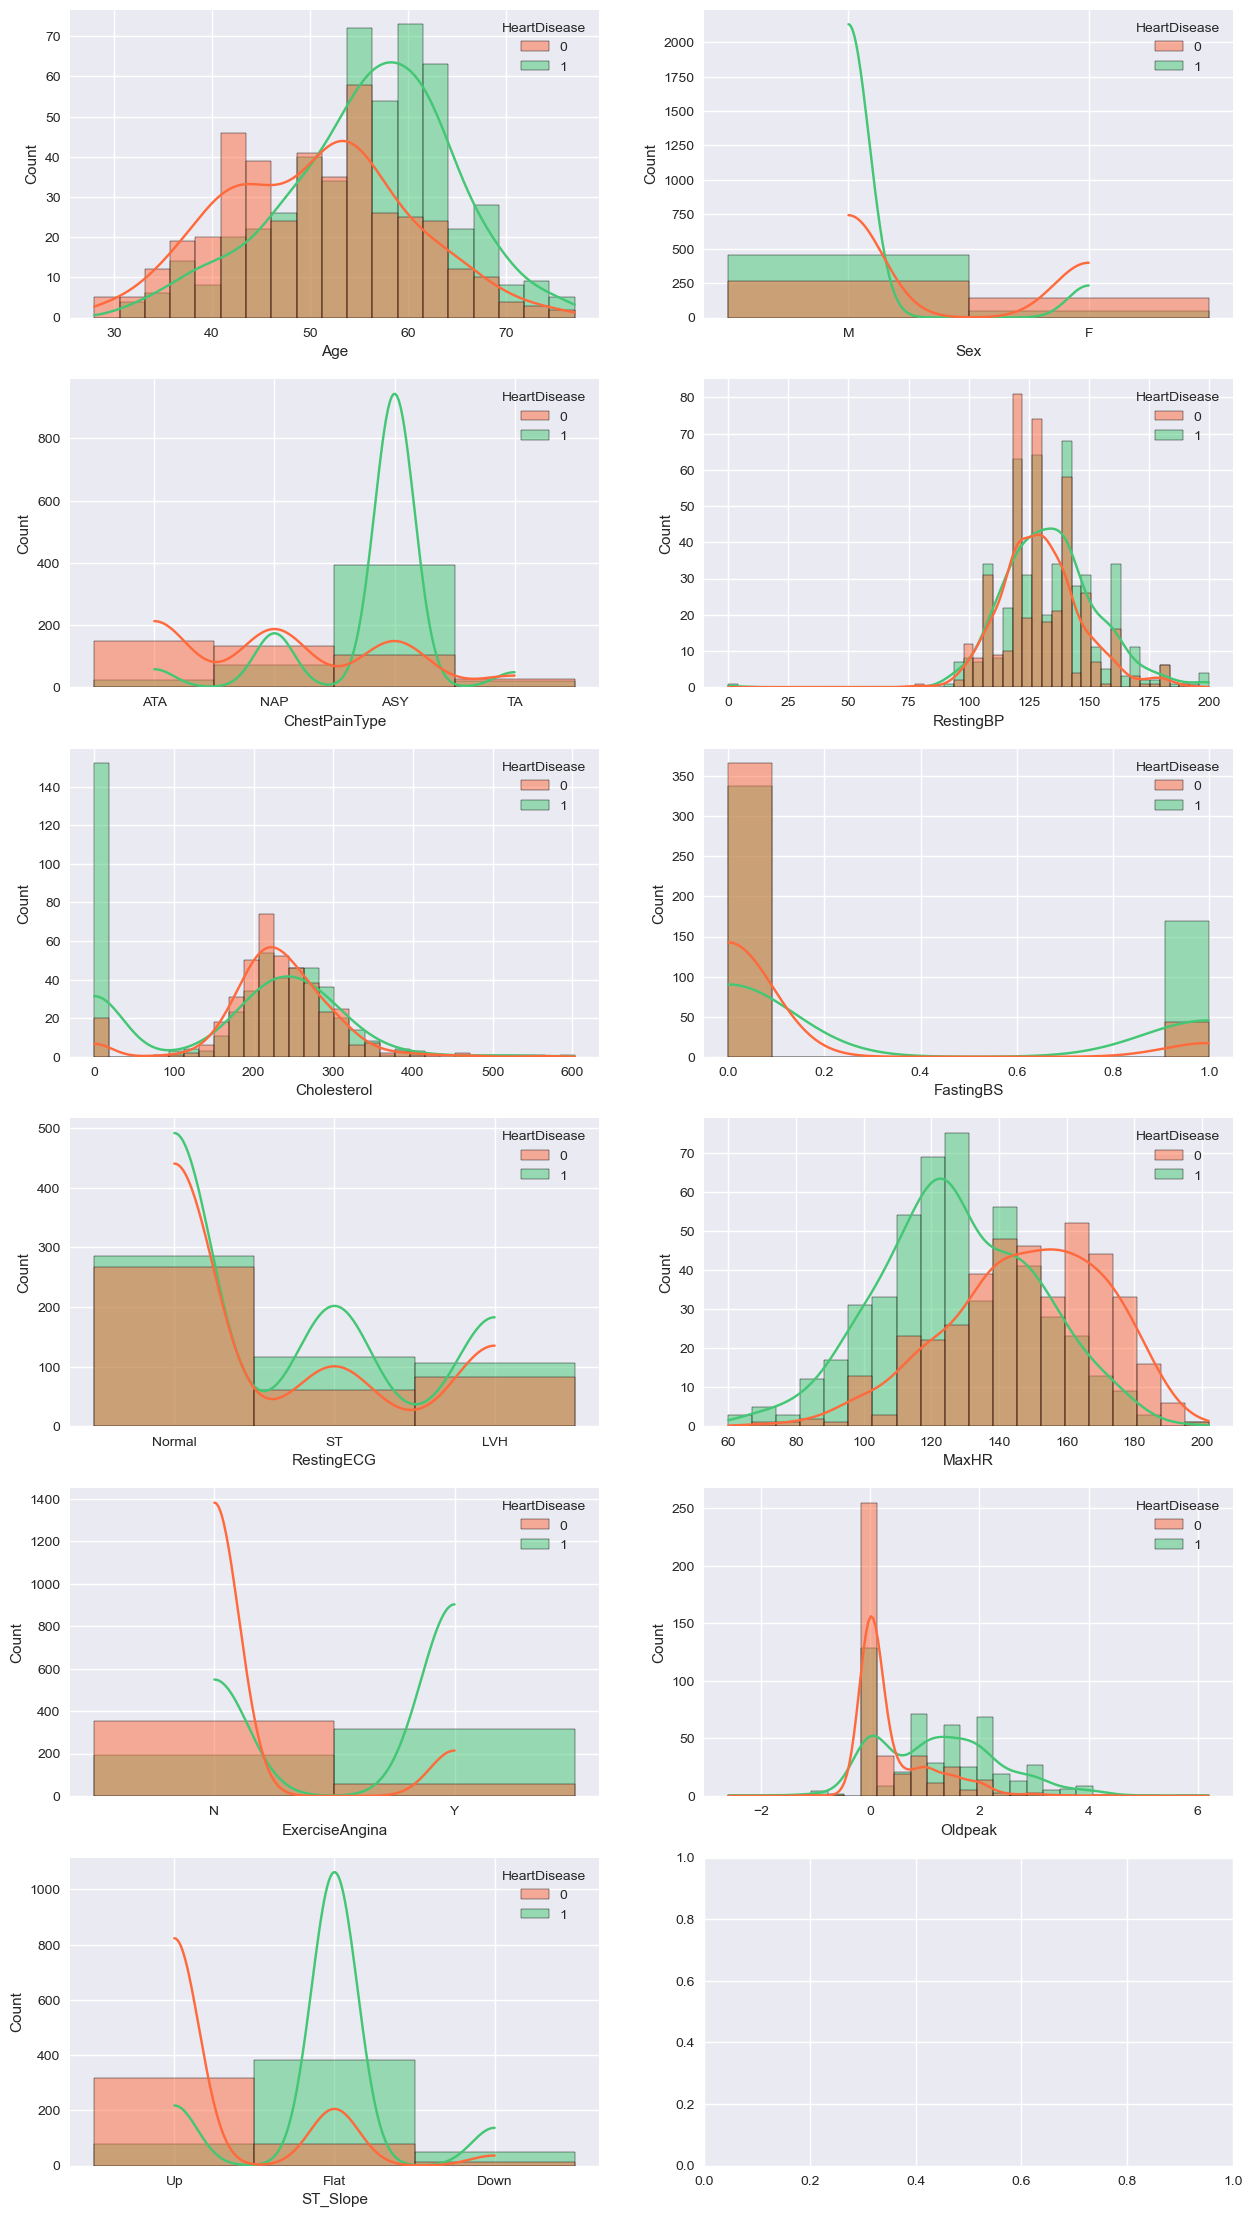

In [65]:

plt.style.use("seaborn")
plt.subplots_adjust(hspace=0.2)
color = ['#ff6a3d','#44c774']

fig, axs = plt.subplots(6, 2, figsize=(15,28))
i=1
for feature in df.columns:
    if feature not in ["HeartDisease"] and i < 14:
        plt.subplot(6,2,i)
        sns.histplot(data=df, x=feature, kde=True, palette=color, hue='HeartDisease')
        i+=1


 Based on this visualization, we will an analysis:
 + **Age**: We see how the risk of suffering cardiovascular diseases (CVDs) increases with age.
 + **Sex**: Apparently the men have a major risk than women of suffering CVDs.
 + **ChestPainType**: The majority cases of CVDs present absence of chest pain or the usual anginal equivalents. Followed by the cases that present chest pain non-anginal.
 + **RestingBP**: According to the [heart.org's article](https://www.heart.org/en/health-topics/high-blood-pressure/health-threats-from-high-blood-pressure/how-high-blood-pressure-can-lead-to-heart-failure), the high blood pressure can drive to suffering CVDs. We see in this histogram a slight increase in the CVDs cases when increase the resting blood pressure. <span style="color:red; font-weight: bold;">Let's observe that exists zero values of blood pressure, this it is incorrect we must treat them</span>.
 + **Cholesterol**: It is well known that a high level of cholesterol can lead to stroke, heart attack, or even heart failure. However, according to the [Heatline's article](https://www.healthline.com/health/serum-cholesterol) not all serum cholesterol is bad, exist three cholesterol types that compose a serum cholesterol, HDL or 'good' cholesterol, LDL or 'bad' cholesterol and triglycerides(TG), where high HDL levels are better than high LDL and TG levels. The level of serum cholesterol (SC) can be calculated like the sum between levels of HDL, LDL and TG, SC[mm/dl] = HDL[mm/dl] + LDL[mm/dl] + TG[mm/dl], note that we don't know the concentrations of HDL, LDL and TG in serum cholesterol of our dataset, but Heatline get us a reference level to determinate when a pacient have risk of suffering CDVs. A serum cholesterol major than 200 mm/dl is considered a risk factor for health, let'us in our histogram that majority cases of CVDs have major levels that 200 mm/dl. In other hand, <span style="color:red; font-weight: bold;">let's observe that exists zero values and value too high (atypical cases) of serum cholesterol, this it is incorrect we must treat them</span>.
 + **FastingBS**: According to [CDC's article](https://www.cdc.gov/diabetes/library/features/diabetes-and-heart.html#:~:text=Over%20time%2C%20high%20blood%20sugar,and%20can%20damage%20artery%20walls.), high blood sugar can damage blood vessels and the nerves that control your heart. For this reason is that patients with diabetes have most risk of suffering CVDs. Our dataset reflect this condition, where the majority of patients with high blood sugar have CVDs.
 + **RestingECG**: The majority cases of patients with CVDs present normal resting electrocardiograms, but we observe that in the cases that present ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) the amount of patients with CVDs are two times more than patientes that not suffering CVDs, something similar occurs with cases that present probable or definite left ventricular hypertrophy but to a lesser degree.
 + **MaxHR**: we don't know the conditions in which they were measured this values, so we can't talk about if this values can be to correct. The truth is that patients with CVDs present low values of maximum heart rate, while that patients with normal conditions present values more high.
 + **ExerciseAngina**: Angina is chest pain or discomfort caused when your heart muscle doesn't get enough oxygen-rich blood. But angina is not a disease. It's a symptom of an underlying heart problem, and for this reason that the majority of patients with CVDs present exercise-induced angina.
 + **Oldpeak**: Also called ST segment depression is a factor that relationed with several CVD, but in some cases this depression can be normal. We can observe that patients with CVDs present high values of depression, though also some patients with CVDs present zero values of depression.
 + **ST_slope**: According to [Ecgwaves's article](https://ecgwaves.com/topic/ecg-st-segment-depression-ischemia-infarction-differential-diagnoses/), upsloping ST segment can be generally considered like normal, but so much flat or horizontal ST segment and dowsloping ST segment can be considered like anomalies, and they are present in the majority cases of patients with CVDs as reflected by our histogram.
 

In [66]:

labels = ["Heart attack" , "No heart attack"]
values = [df[df["HeartDisease"] == 1].count().to_numpy()[0],
         df[df["HeartDisease"] == 0].count().to_numpy()[0]]

fig = go.Figure(data=[go.Pie(labels=labels, 
                             values=values, 
                             marker_colors=color,
                             textinfo='label+percent'
                            )])
fig.update(layout_title_text='Heart disease', layout_showlegend=False)
fig.show()

Here we can see that our dataset provide 2 classes with a very balance data

## 🧹Data Cleansing

In [67]:

print(f'There are {df.shape[0]} rows and {df.shape[1]} columns in the dataset')

There are 918 rows and 12 columns in the dataset


### 1. **Duplicate** and **Null value** Detection

In [68]:

print(f'There are {df.duplicated().sum()} duplicated value in our dataset')

There are 0 duplicated value in our dataset


In [69]:

print('Total null value in each columns')
print(df.isnull().sum())

Total null value in each columns
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


So there is no duplicate and null value which is great. <br>
##### Now we look more into what **data types** are there.

In [70]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


### 2. **Outlier** Detection

We have previously seen that features like cholesterol and resting blood pressure present atypical cases, this cases not represent the condition of general population and this data type we don't useful to train our model of predictions, let's see how to treat them:

In [71]:

def detect_outliers(label=None):
    Q1 = df[label].quantile(0.25)
    Q3 = df[label].quantile(0.75)
    IQR = Q3 - Q1
    interval = ((df[label] > Q1 - 1.5*IQR) & (df[label] < Q3 + 1.5*IQR))
    return df[interval], df[~interval]

def assign_mean(df_out, not_df_out, label=None):
    df.loc[df_out[df_out["HeartDisease"] == 0].index, label] = not_df_out[not_df_out["HeartDisease"] == 0][label].mean()
    df.loc[df_out[df_out["HeartDisease"] == 1].index, label] = not_df_out[not_df_out["HeartDisease"] == 1][label].mean()
    return

def delete_outliers(df_out):
    return df.drop(df_out.index)

#### a. Cholesterol

<AxesSubplot:xlabel='Cholesterol'>

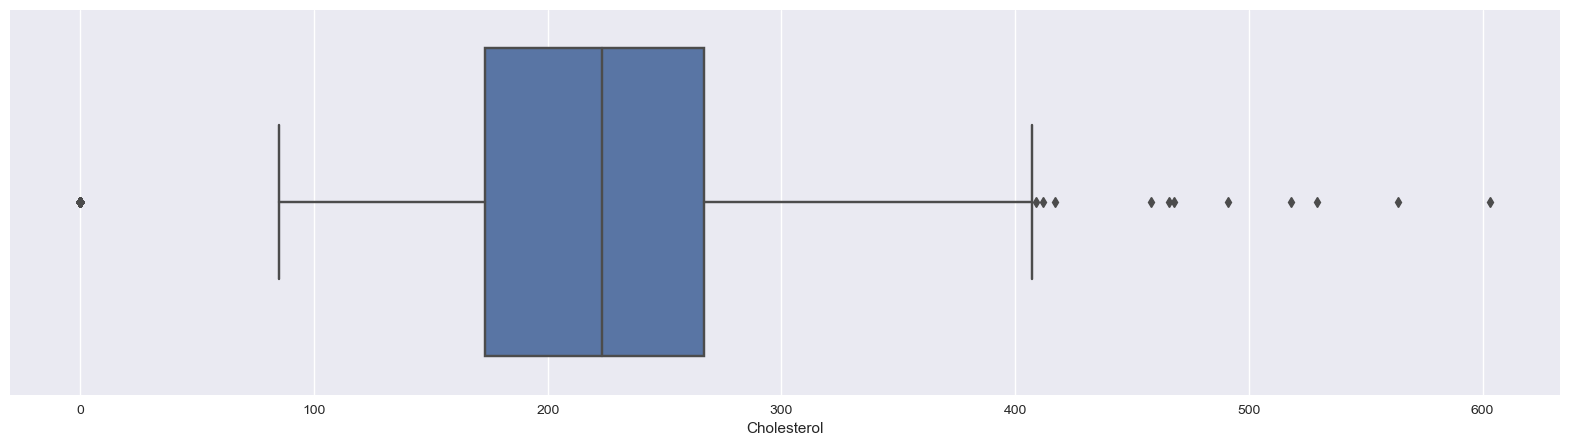

In [72]:

plt.figure(figsize=(20,5))
sns.boxplot(data=df, x="Cholesterol")

In [73]:
not_df_out_ch, df_out_ch = detect_outliers('Cholesterol')
print(f'Outliers in cholesterol represent the {round((df_out_ch.shape[0]*100)/df.shape[0], 2)}% of our dataset')
df_out_ch

Outliers in cholesterol represent the 19.93% of our dataset


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
28,53,F,ATA,113,468,0,Normal,127,N,0.0,Up,0
30,53,M,NAP,145,518,0,Normal,130,N,0.0,Flat,1
69,44,M,ASY,150,412,0,Normal,170,N,0.0,Up,0
76,32,M,ASY,118,529,0,Normal,130,N,0.0,Flat,1
103,40,M,ASY,120,466,1,Normal,152,Y,1.0,Flat,1
...,...,...,...,...,...,...,...,...,...,...,...,...
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1
536,62,M,NAP,133,0,1,ST,119,Y,1.2,Flat,1
616,67,F,NAP,115,564,0,LVH,160,N,1.6,Flat,0
667,65,F,NAP,140,417,1,LVH,157,N,0.8,Up,0


These outliers represent the 19.93% of our dataset. There are some of them is zero values (these are human errors) <br>
We think the best solution is to deleted those zero while the rest of the outliers will be assigned with the mean value of cholesterol column. Because we just cant delete ~20% of the dataset.

<AxesSubplot:xlabel='Cholesterol', ylabel='Count'>

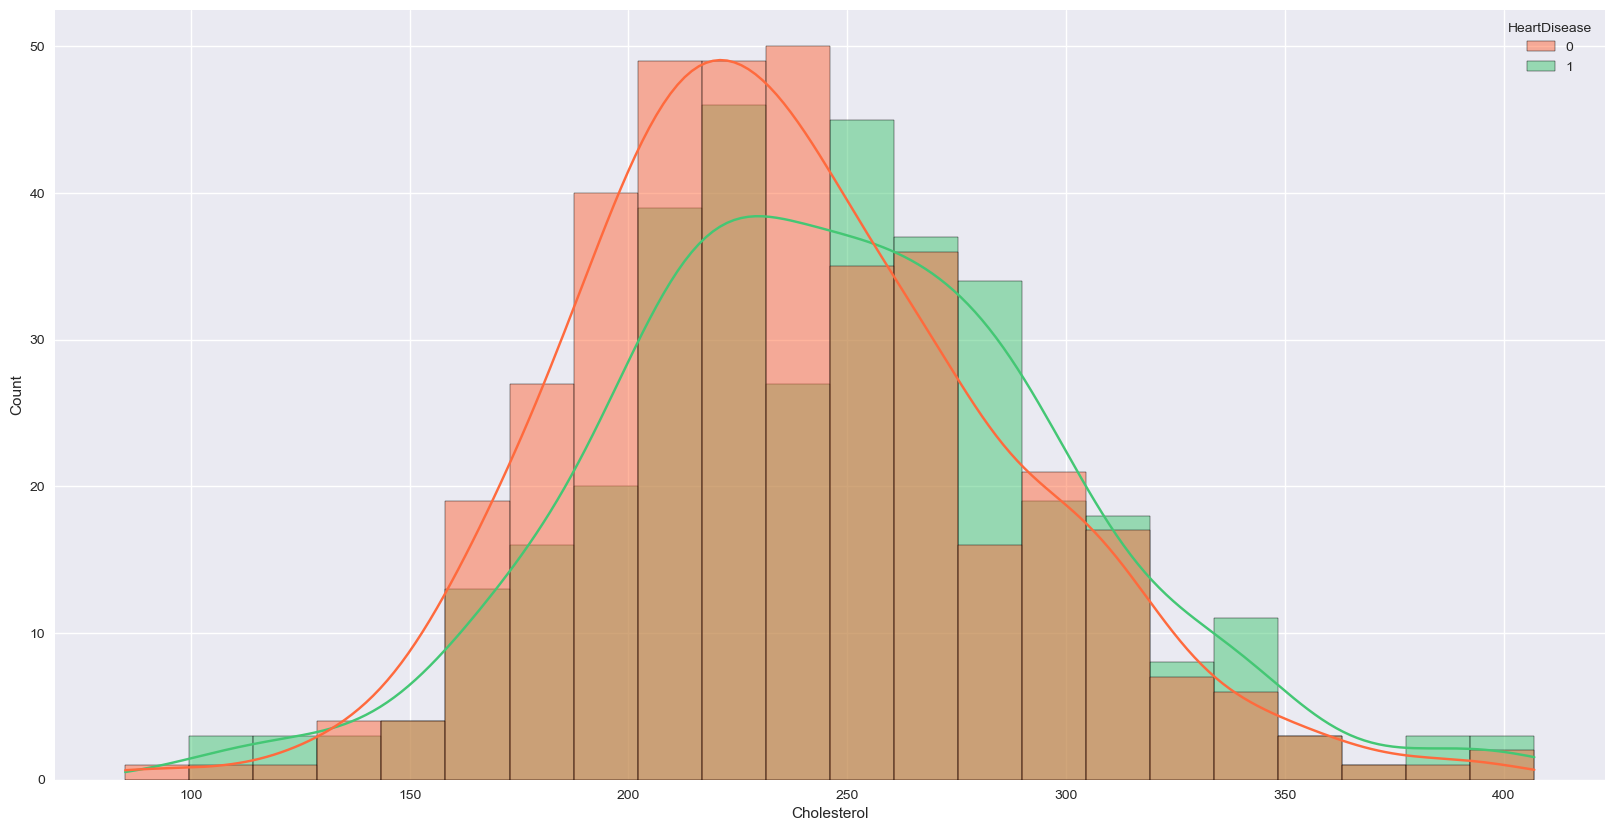

In [74]:
df = delete_outliers(df_out_ch[df_out_ch["Cholesterol"] == 0])
assign_mean(df_out_ch[df_out_ch["Cholesterol"] != 0], not_df_out_ch, 'Cholesterol')

plt.figure(figsize=(20,10))
sns.histplot(data=df, x='Cholesterol', kde=True, palette=color, hue='HeartDisease')

#### b. Resting Blood Pressure

<AxesSubplot:xlabel='RestingBP'>

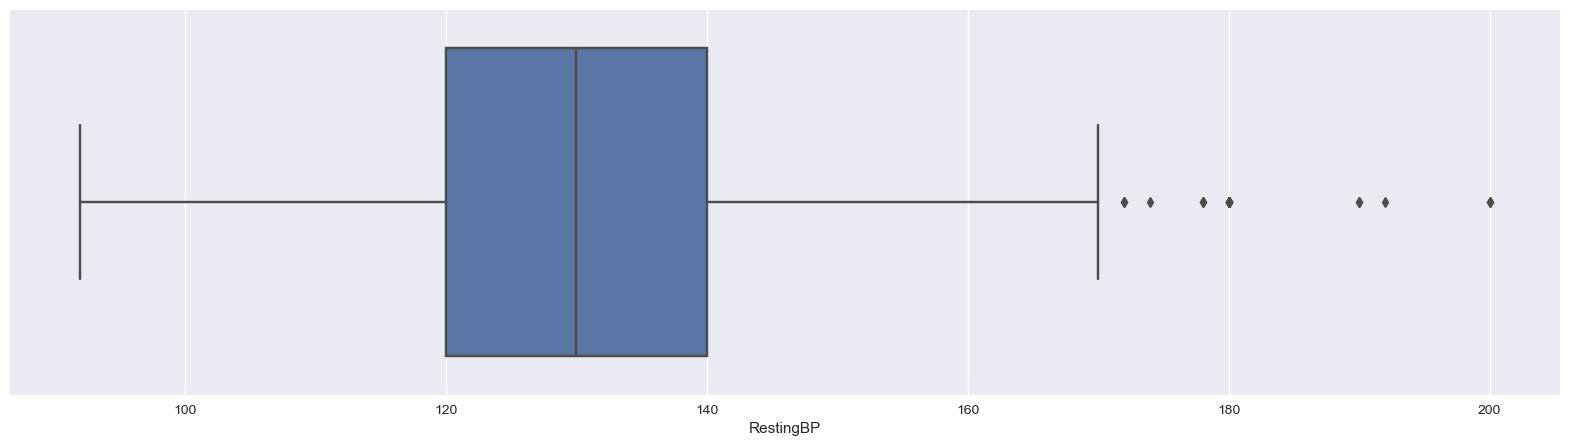

In [75]:

plt.figure(figsize=(20,5))
sns.boxplot(data=df, x="RestingBP")

In [76]:
not_df_out_rbp, df_out_rbp = detect_outliers('RestingBP')
print(f'Outliers in resting blood pressure represent the {round((df_out_rbp.shape[0]*100)/df.shape[0], 2)}% of our dataset')
df_out_rbp

Outliers in resting blood pressure represent the 4.29% of our dataset


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
86,65,M,ASY,170,263.0,1,Normal,112,Y,2.0,Flat,1
109,39,M,ATA,190,241.0,0,Normal,106,N,0.0,Up,0
123,58,F,ATA,180,393.0,0,Normal,110,Y,1.0,Flat,1
132,56,M,ASY,170,388.0,0,ST,122,Y,2.0,Flat,1
189,53,M,ASY,180,285.0,0,ST,120,Y,1.5,Flat,1
190,46,M,ASY,180,280.0,0,ST,120,N,0.0,Up,0
191,50,M,ATA,170,209.0,0,ST,116,N,0.0,Up,0
215,30,F,TA,170,237.0,0,ST,170,N,0.0,Up,0
241,54,M,ASY,200,198.0,0,Normal,142,Y,2.0,Flat,1
274,45,F,ATA,180,295.0,0,Normal,180,N,0.0,Up,0


In this case the outliers in resting blood pressure represent the 4.58% of total cases, we can delete them.

<AxesSubplot:xlabel='RestingBP', ylabel='Count'>

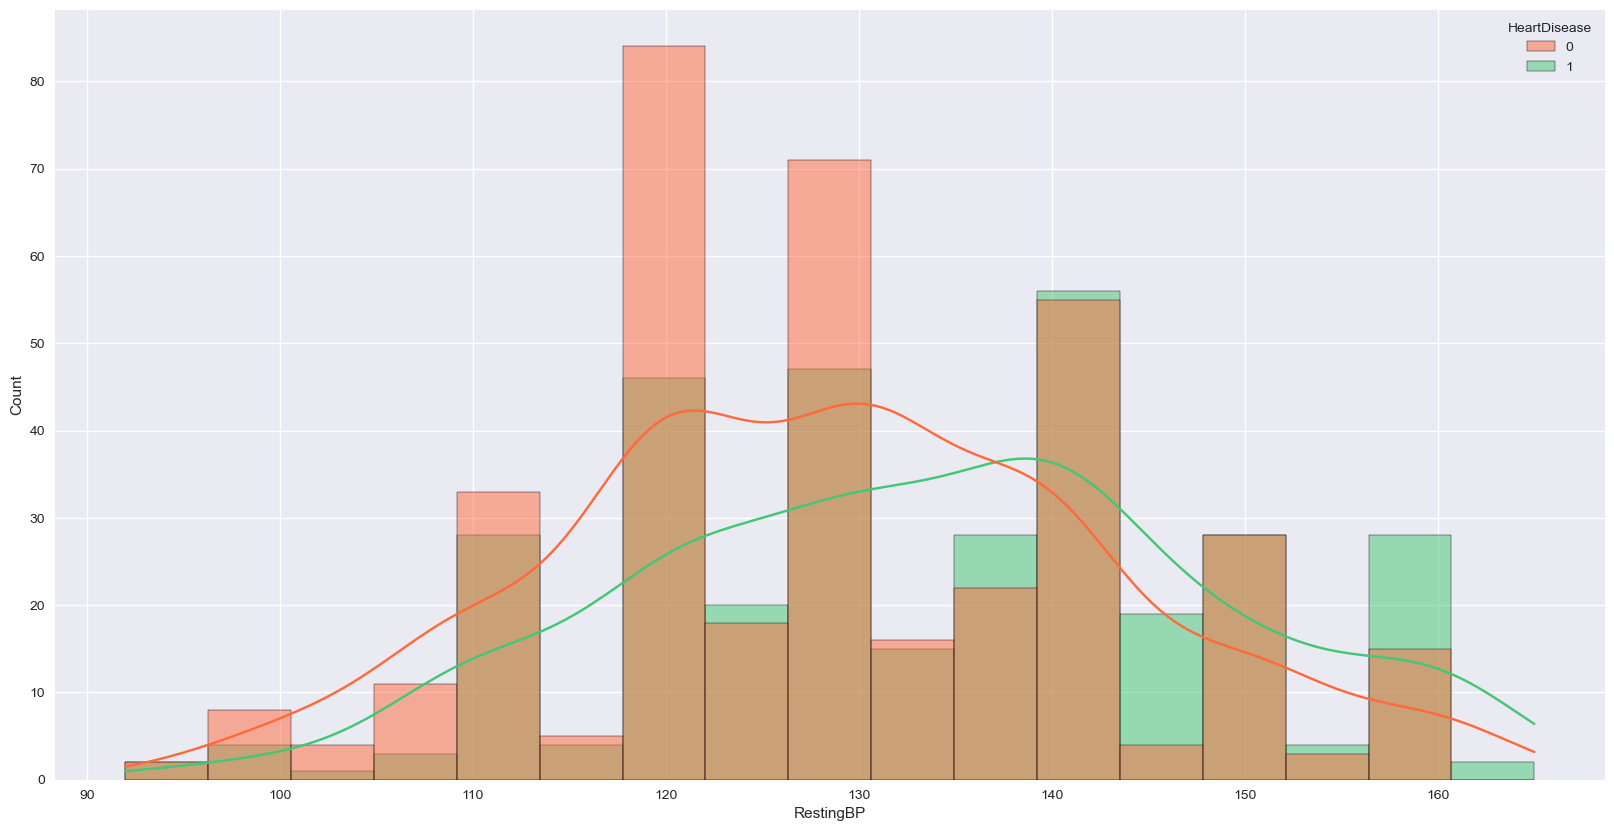

In [77]:
df = delete_outliers(df_out_rbp)
plt.figure(figsize=(20,10))
sns.histplot(data=df, x='RestingBP', kde=True, palette=color, hue='HeartDisease')

## 🔢 Features encoding

### 1. Binary features enconding

In [78]:

df["Sex"] = df["Sex"].map({'M':1, 'F':0})
df["ExerciseAngina"] = df["ExerciseAngina"].map({'N':0, 'Y':1})
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,ATA,140,289.0,0,Normal,172,0,0.0,Up,0
1,49,0,NAP,160,180.0,0,Normal,156,0,1.0,Flat,1
2,37,1,ATA,130,283.0,0,ST,98,0,0.0,Up,0
3,48,0,ASY,138,214.0,0,Normal,108,1,1.5,Flat,1
4,54,1,NAP,150,195.0,0,Normal,122,0,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,TA,110,264.0,0,Normal,132,0,1.2,Flat,1
914,68,1,ASY,144,193.0,1,Normal,141,0,3.4,Flat,1
915,57,1,ASY,130,131.0,0,Normal,115,1,1.2,Flat,1
916,57,0,ATA,130,236.0,0,LVH,174,0,0.0,Flat,1


### 2. Data Binning

In [79]:

df_bin = df.copy()
for feature in continuos_f:
    bins = 5
    df_bin[feature] = pd.cut(df[feature], bins=bins, labels=range(bins)).astype(np.int64)
df_bin

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,1,1,ATA,3,3,0,Normal,3,0,0,Up,0
1,2,0,NAP,4,1,0,Normal,3,0,0,Flat,1
2,0,1,ATA,2,3,0,ST,1,0,0,Up,0
3,2,0,ASY,3,2,0,Normal,1,1,1,Flat,1
4,2,1,NAP,3,1,0,Normal,1,0,0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,1,1,TA,1,2,0,Normal,2,0,1,Flat,1
914,4,1,ASY,3,1,1,Normal,2,0,2,Flat,1
915,2,1,ASY,2,0,0,Normal,1,1,1,Flat,1
916,2,0,ATA,2,2,0,LVH,3,0,0,Flat,1


### 3. One-hot encoding

In [80]:
df_dumm = pd.get_dummies(df_bin, columns = categorical_f+continuos_f)
df_dumm

,Sex,FastingBS,ExerciseAngina,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,...,MaxHR_0,MaxHR_1,MaxHR_2,MaxHR_3,MaxHR_4,Oldpeak_0,Oldpeak_1,Oldpeak_2,Oldpeak_3,Oldpeak_4
0,1,0,0,0,0,1,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
1,0,0,0,1,0,0,1,0,0,1,...,0,0,0,1,0,1,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,0,0,1,1,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,1,0,0,1,0,0,0,1,0,1,...,0,0,1,0,0,0,1,0,0,0
914,1,1,0,1,1,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
915,1,0,1,1,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
916,0,0,0,1,0,1,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0


## ⚖️ Correlations

<AxesSubplot:>

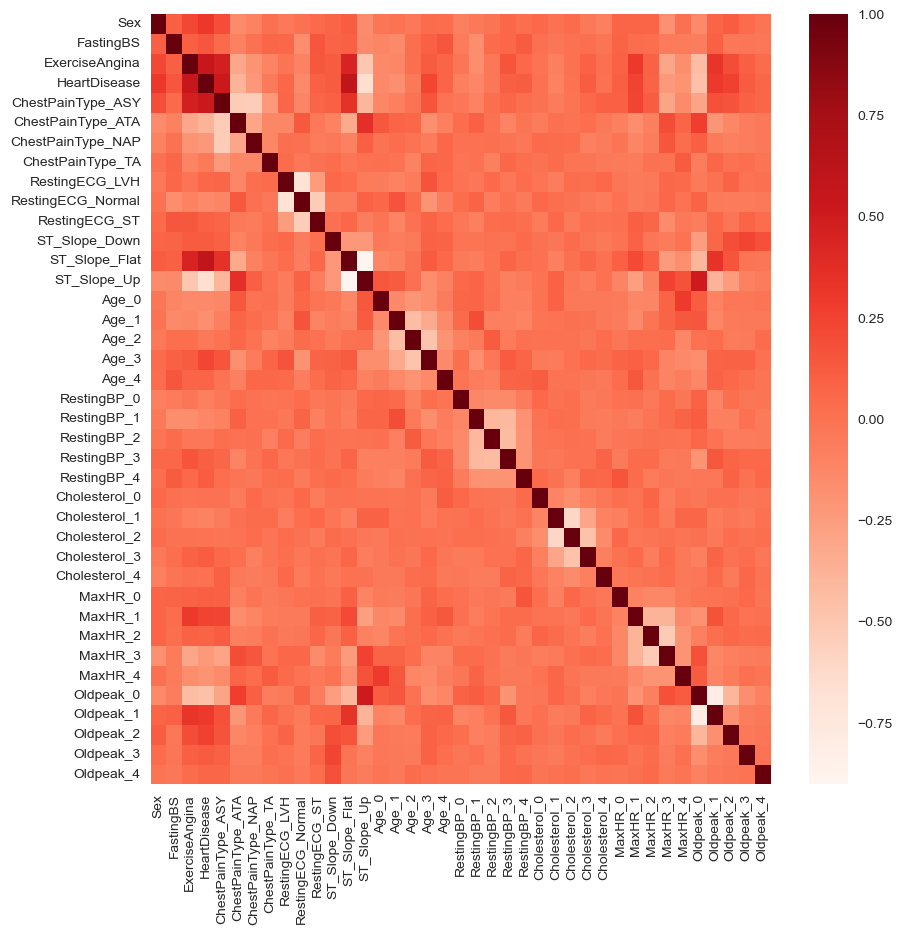

In [81]:

plt.figure(figsize=(10,10))
cor = df_dumm.corr()
sns.heatmap(cor, cmap=plt.cm.Reds, fmt='.2f')


It is a huge matrix with too many features. We will check the correlation only with respect to **HeartDisease**

Text(0.5, 1.0, 'Correlation with HeartDisease')

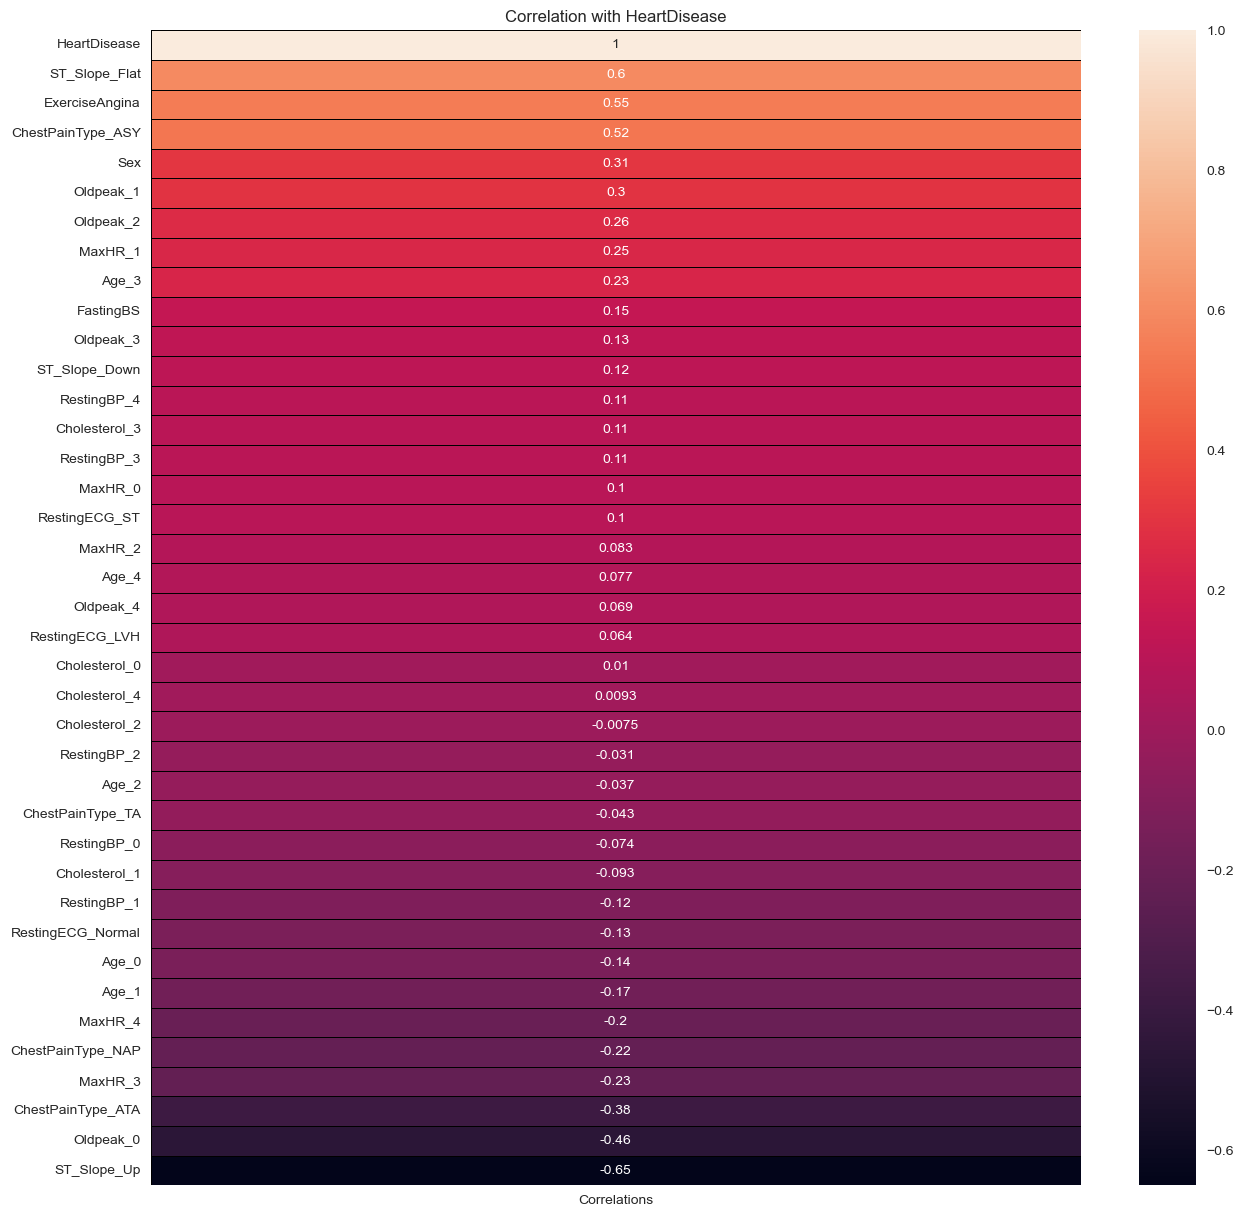

In [82]:

corr = df_dumm.corrwith(df_dumm['HeartDisease']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (15, 15))
sns.heatmap(corr,annot = True,linewidths = 0.4,linecolor = 'black')
plt.title('Correlation with HeartDisease')

## ✂️Training and Test Sets Split

In [22]:
# đoạn code được tạo bởi bản sao của df_dumm
# sau đó biến x được tạo thành và bỏ cột HeartDisease từ df_clean 
# Dữ liệu sau đó được chia thành các tập huấn luyện và kiểm tra sử dụng hàm train_test_split từ scikit-learn. 
# Tham số test_size chỉ định rằng 20% dữ liệu sẽ được sử dụng để kiểm tra và phần còn lại để huấn luyện. 
# Tham số random_state đảm bảo rằng việc chia là có thể tái sản xuất. 
# Tham số stratify đảm bảo rằng tỷ lệ các lớp trong cả hai tập huấn luyện và kiểm tra giống nhau với tỷ lệ trong tập dữ liệu gốc.
df_clean = df_dumm.copy()

X = df_clean.drop(["HeartDisease"], axis=1)
y = df_clean["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

## 🤖 Modeling

We will train four models to tasks of classification also we will use grid search to tuning models' hyperparameters, additionally we will evaluate their performance with confusion matrix where:

<table>
    <tr>
        <th colspan="2" rowspan="2"></th>
        <th colspan="2">Predicted</th>
    </tr>
    <tr>
        <td>Negative</td>
        <td>Positive</td>
    </tr>
    <tr>
        <th rowspan="2">Actual</th>
        <td>Negative</td>
        <td>TN</td>
        <td>FP</td>
    </tr>
    <tr>
        <td>Positive</td>
        <td>FN</td>
        <td>TP</td>
    </tr>
</table>

Taking into account that:
+ Case negative: Patients with normal conditions (NC)
+ Case positive: Patients with CVDs
+ TN: The prediction tells us that the patient has NC when actually has NC.
+ TP: The prediction tells us that the patient has CVDs when actually has CVDs.
+ FN: The prediction tells us that the patient has NC when actually has CVDs.
+ FP: The prediction tells us that the patient has CVDs when actually has NC.

And because our dataset has very balanced classes so we decided to use ROC curve to measure the performance of a classifier

**Function to plot ROC curve and give the scores of models**

In [23]:
# Hàm vẽ_đường_roc nhận ba tham số: fpr, tpr, và một tham số tùy chọn label. Nó sử dụng thư viện matplotlib để vẽ đường cong ROC (receiver operating characteristic) 
# với tỷ lệ dương tính giả (fpr) và tỷ lệ dương tính thực (tpr) đã cho. Hàm cũng vẽ một đường chéo từ (0, 0) đến (1 , 1) bằng một đường nét đứt màu đen. 
# Trục x được ghi nhãn “Tỷ lệ dương tính giả” và trục y được ghi nhãn “Tỷ lệ dương tính thực”.
# Hàm in_điểm nhận hai tham số: y và y_dự_đoán. Nó tính toán các điểm số của các dự đoán (y_dự_đoán) so với các nhãn chân thật (y) sử dụng các hàm từ thư viện scikit-learn. 
# Các điểm số này được in ra màn hình console.
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1]) 
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Poisitive Rate")
    
def print_scores(y, y_pred):
    ac, pr, rc, f1 = accuracy_score(y, y_pred)*100, precision_score(y, y_pred)*100, recall_score(y, y_pred)*100, f1_score(y, y_pred, average='weighted')*100
    print(f'Accuracy: {ac}')
    print(f'Precision: {pr}')
    print(f'Recall: {rc}')
    print(f'F1-score: {f1}')
    return {'Accuracy': ac, 'Precision':pr, 'Recall':rc, 'F1-score':f1}

**State Parameters used for GridSearchCV**

In [24]:
# Phép đo để đánh giá mô hình là recall và sẽ thực hiện kiểm định chéo với 15 lần.
metric = 'recall'
cv = 15

## 🟡 Logistic Regression Classifier

#### We train the model

In [25]:
param_grid = [{
    "C": np.linspace(1, 1.5, 10),
    'penalty' : ['l1','l2'],
}]

lgr_clf = LogisticRegression()
grid_lgr = GridSearchCV(lgr_clf, param_grid, scoring=metric, cv=cv)
grid_lgr.fit(X_train, y_train)

GridSearchCV(cv=15, estimator=LogisticRegression(),
             param_grid=[{'C': array([1.        , 1.05555556, 1.11111111, 1.16666667, 1.22222222,
       1.27777778, 1.33333333, 1.38888889, 1.44444444, 1.5       ]),
                          'penalty': ['l1', 'l2']}],
             scoring='recall')

In [26]:
best_lgr_clf = grid_lgr.best_estimator_
grid_lgr.best_params_

{'C': 1.0, 'penalty': 'l2'}

<AxesSubplot:>

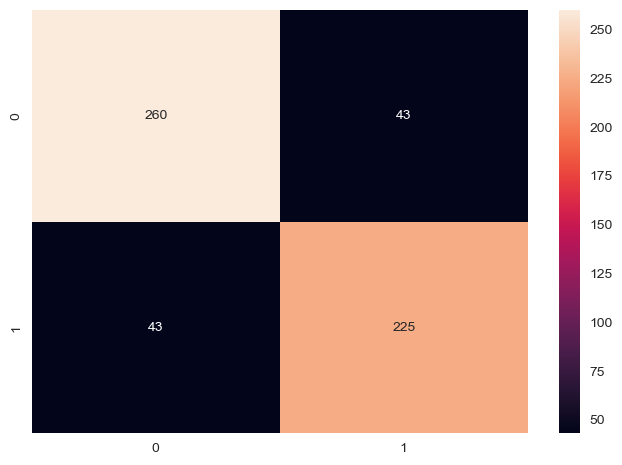

In [27]:
y_train_pred = cross_val_predict(best_lgr_clf, X_train, y_train, cv=cv)
conf_mx = confusion_matrix(y_train, y_train_pred)
sns.heatmap(conf_mx, annot=True, fmt='')

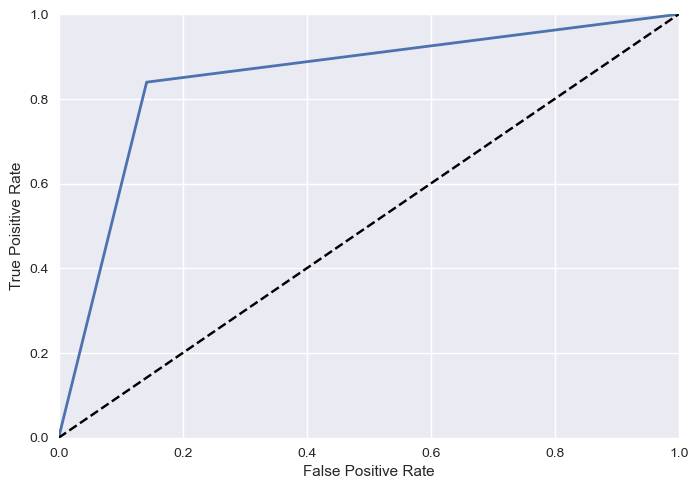

In [28]:
fpr_lgr, tpr_lgr, thresholds_lgr = roc_curve(y_train, y_train_pred)
plot_roc_curve(fpr_lgr, tpr_lgr, "Logistic Regression")
plt.show()

In [29]:
roc_auc_score(y_train, y_train_pred)

0.848819023693414

#### We evaluate the model with test set:

<AxesSubplot:>

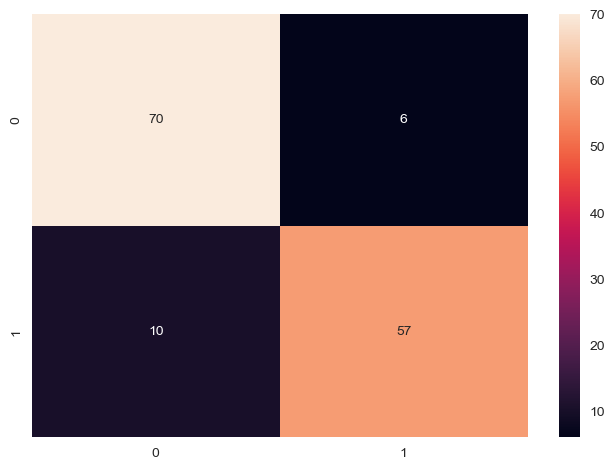

In [30]:
y_test_pred = cross_val_predict(best_lgr_clf, X_test, y_test, cv=cv)
conf_mx = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_mx, annot=True, fmt='')

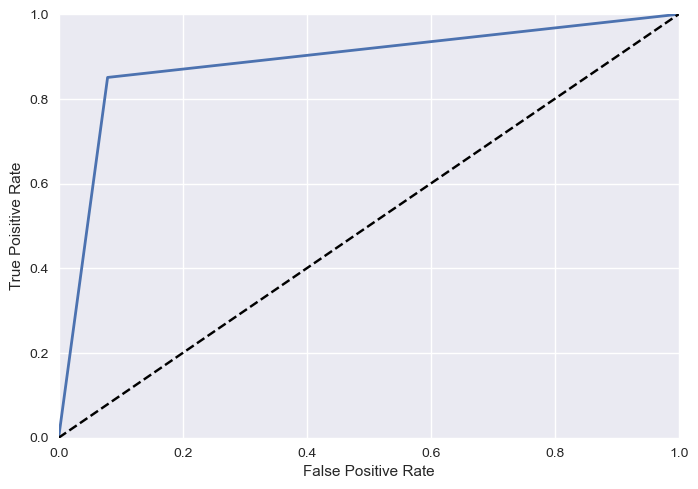

In [31]:
fpr_lgr, tpr_lgr, thresholds_lgr = roc_curve(y_test, y_test_pred)
plot_roc_curve(fpr_lgr, tpr_lgr, "Logistic Regression")
plt.show()

In [32]:
roc_auc_score(y_test, y_test_pred)

0.8858994501178319

#### We calculate the scores

In [33]:
lgr_scores = print_scores(y_test, y_test_pred)

Accuracy: 88.81118881118881
Precision: 90.47619047619048
Recall: 85.07462686567165
F1-score: 88.78249955173033


## 🟣 K-Nearest Neighbors Classifier

#### We train the model

In [34]:
param_grid = [{
    'n_neighbors':np.arange(5, 21),
    'weights':['uniform', 'distance'],
    'p':[1, 2],
}]

knn_clf = KNeighborsClassifier()
grid_knn = GridSearchCV(knn_clf, param_grid, cv=cv, scoring=metric)
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=15, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
                          'p': [1, 2], 'weights': ['uniform', 'distance']}],
             scoring='recall')

In [35]:
best_knn_clf = grid_knn.best_estimator_
grid_knn.best_params_

{'n_neighbors': 9, 'p': 2, 'weights': 'distance'}

<AxesSubplot:>

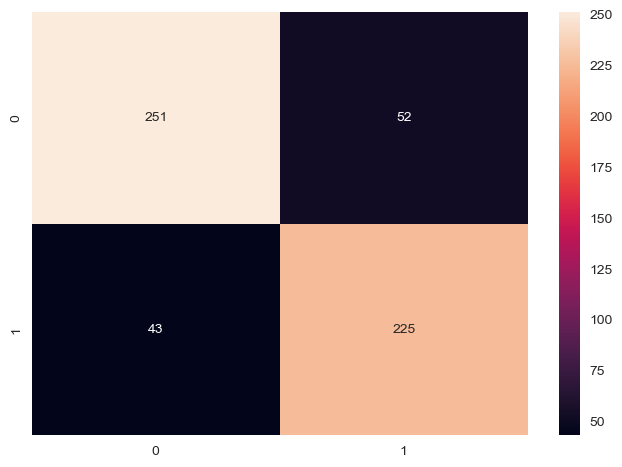

In [36]:
y_train_pred = cross_val_predict(best_knn_clf, X_train, y_train, cv=cv)
conf_mx = confusion_matrix(y_train, y_train_pred)
sns.heatmap(conf_mx, annot=True, fmt='')

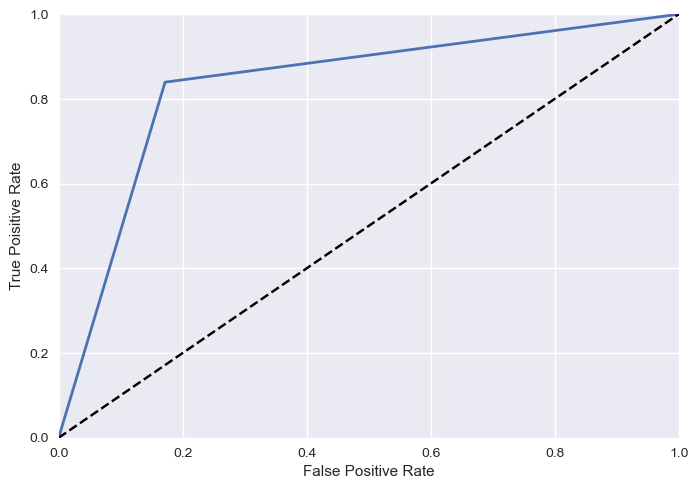

In [37]:
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_train, y_train_pred)
plot_roc_curve(fpr_knn, tpr_knn, "K-Nearest Neighbors")
plt.show()

In [38]:
roc_auc_score(y_train, y_train_pred)

0.8339675385448992

#### We evaluate the model with test set:

<AxesSubplot:>

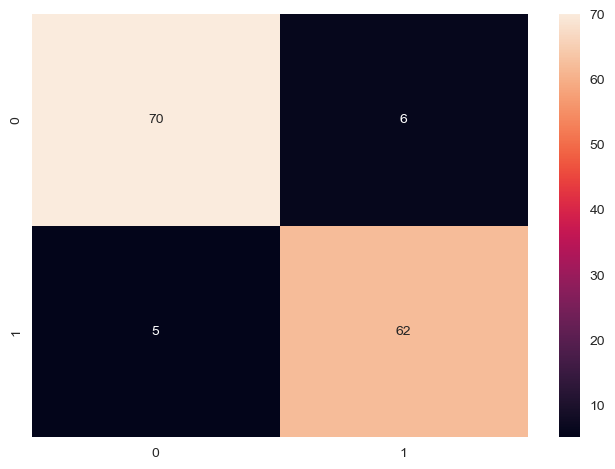

In [39]:
y_test_pred = cross_val_predict(best_knn_clf, X_test, y_test, cv=cv)
conf_mx = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_mx, annot=True, fmt='')

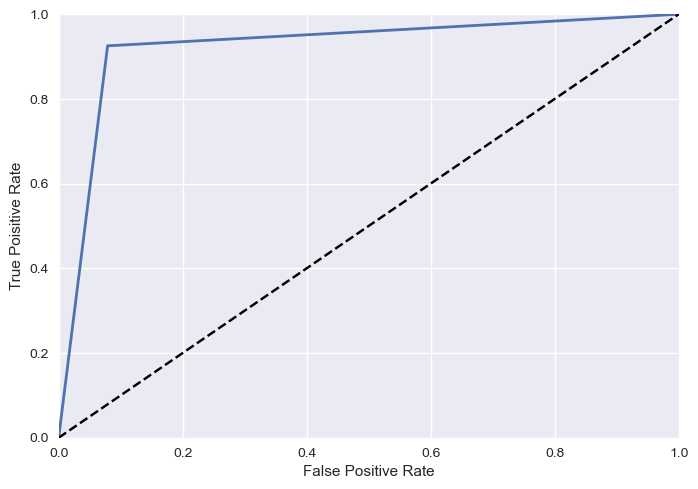

In [40]:
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_test_pred)
plot_roc_curve(fpr_knn, tpr_knn, "K-Nearest Neighbors")
plt.show()

In [41]:
roc_auc_score(y_test, y_test_pred)

0.9232128829536528

#### We calculate the scores

In [42]:
knn_scores = print_scores(y_test, y_test_pred)

Accuracy: 92.3076923076923
Precision: 91.17647058823529
Recall: 92.53731343283582
F1-score: 92.31071111865813


## 🟠 Support Vector Machine Classifier

#### We train the model

In [43]:
param_grid = [{
    "C": np.linspace(1, 1.5, 10),
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "gamma": ['scale', 'auto']
}]

svc_clf = SVC()
grid_svc = GridSearchCV(svc_clf, param_grid, scoring=metric, cv=cv)
grid_svc.fit(X_train, y_train)

GridSearchCV(cv=15, estimator=SVC(),
             param_grid=[{'C': array([1.        , 1.05555556, 1.11111111, 1.16666667, 1.22222222,
       1.27777778, 1.33333333, 1.38888889, 1.44444444, 1.5       ]),
                          'gamma': ['scale', 'auto'],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}],
             scoring='recall')

In [44]:
best_svc_clf = grid_svc.best_estimator_
grid_svc.best_params_

{'C': 1.0, 'gamma': 'auto', 'kernel': 'sigmoid'}

<AxesSubplot:>

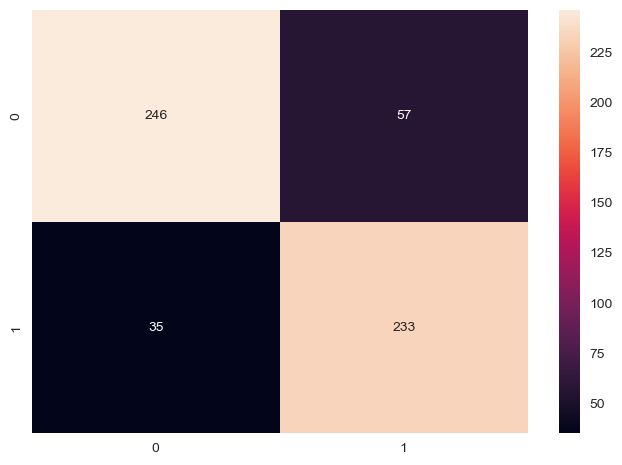

In [45]:
y_train_pred = cross_val_predict(best_svc_clf, X_train, y_train, cv=cv)
conf_mx = confusion_matrix(y_train, y_train_pred)
sns.heatmap(conf_mx, annot=True, fmt='')

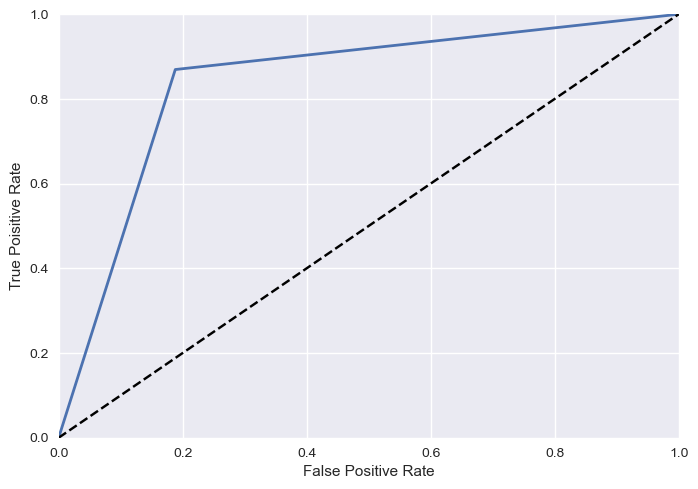

In [46]:
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_train, y_train_pred)
plot_roc_curve(fpr_svc, tpr_svc, "SVC")
plt.show()

In [47]:
roc_auc_score(y_train, y_train_pred)

0.8406420865967195

#### We evaluate the model with test set:

<AxesSubplot:>

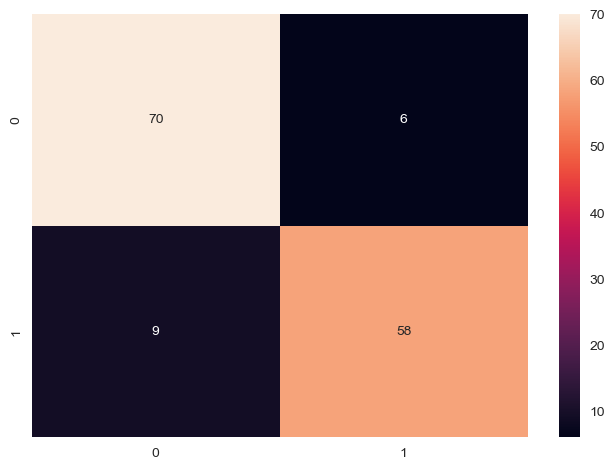

In [48]:
y_test_pred = cross_val_predict(best_svc_clf, X_test, y_test, cv=cv)
conf_mx = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_mx, annot=True, fmt='')

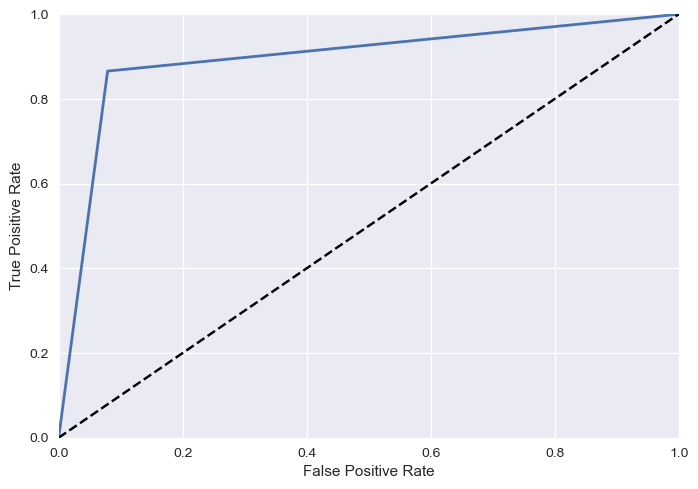

In [49]:
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_test_pred)
plot_roc_curve(fpr_svc, tpr_svc, "SVC")
plt.show()

In [50]:
roc_auc_score(y_test, y_test_pred)

0.893362136684996

#### We calculate the scores

In [51]:
svc_scores = print_scores(y_test, y_test_pred)

Accuracy: 89.5104895104895
Precision: 90.625
Recall: 86.56716417910447
F1-score: 89.49189200358863


## 🟢 Random Forest Classifier

#### We train the model

In [52]:
nFeatures = len(X_train.columns)
param_grid = [{"n_estimators":[25, 50, 75],
               'criterion':['gini','entropy'],
               "max_features":[nFeatures-10, nFeatures-5]
              }]
rf_clf = RandomForestClassifier(random_state=42)
grid_forest = GridSearchCV(rf_clf, param_grid, cv=cv, scoring=metric)
grid_forest.fit(X_train, y_train)

GridSearchCV(cv=15, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_features': [28, 33],
                          'n_estimators': [25, 50, 75]}],
             scoring='recall')

In [53]:
best_rf_clf = grid_forest.best_estimator_
grid_forest.best_params_

{'criterion': 'entropy', 'max_features': 28, 'n_estimators': 25}

<AxesSubplot:>

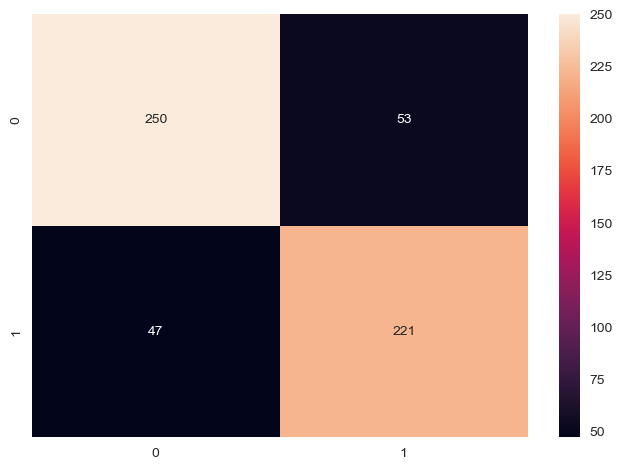

In [54]:
y_train_pred = cross_val_predict(best_rf_clf, X_train, y_train, cv=cv)
conf_mx = confusion_matrix(y_train, y_train_pred)
sns.heatmap(conf_mx, annot=True, fmt='')

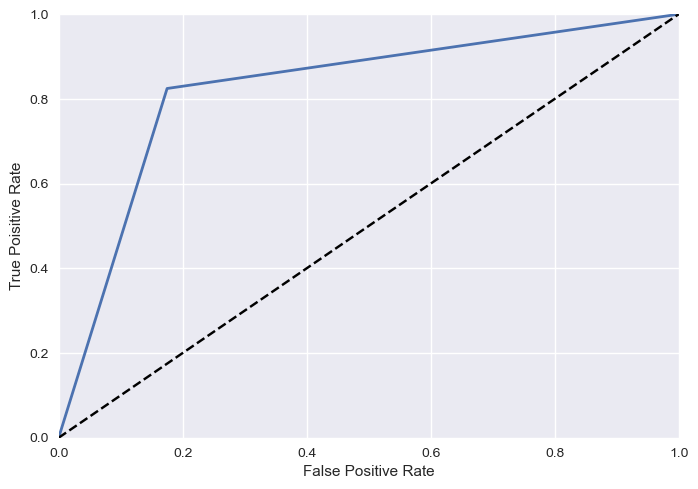

In [55]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_train_pred)
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.show()

In [56]:
roc_auc_score(y_train, y_train_pred)

0.8248546869612334

#### We evaluate the model with test set:

<AxesSubplot:>

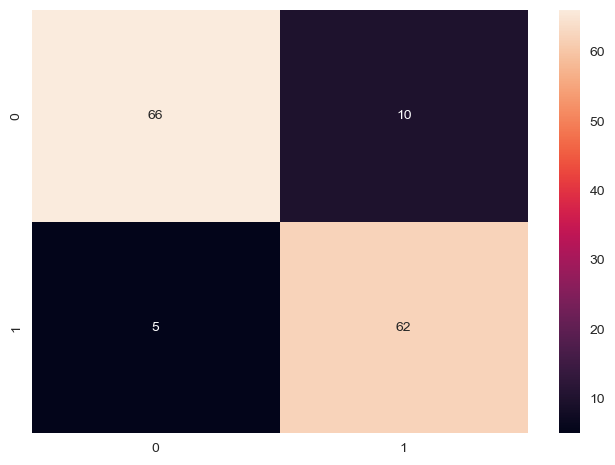

In [57]:
y_test_pred = cross_val_predict(best_rf_clf, X_test, y_test, cv=cv)
conf_mx = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_mx, annot=True, fmt='')

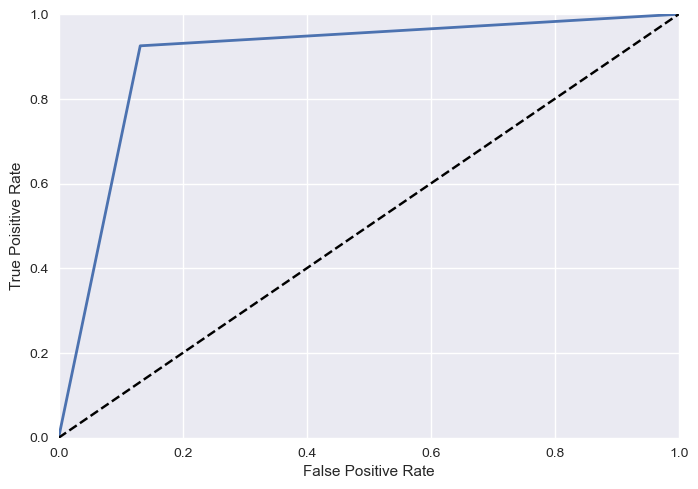

In [58]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test, y_test_pred)
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.show()

In [59]:
roc_auc_score(y_test, y_test_pred)

0.8968970934799686

#### We calculate the scores

In [60]:
rf_scores = print_scores(y_test, y_test_pred)

Accuracy: 89.5104895104895
Precision: 86.11111111111111
Recall: 92.53731343283582
F1-score: 89.52075673555633


## 📏 Model Score Comparisons

In [61]:
scores = pd.DataFrame(data=[list(lgr_scores.values()), list(knn_scores.values()), list(svc_scores.values()), list(rf_scores.values())], columns=list(lgr_scores.keys()))
scores = scores.transpose()
scores = scores.rename(columns={0:"Logistic Regression", 1:"K-Nearest Neighbors", 2:"Support Vector Machine", 3:"Random Forest"})
scores.style.highlight_max(color='green', axis = 1)

,Logistic Regression,K-Nearest Neighbors,Support Vector Machine,Random Forest
Accuracy,88.811189,92.307692,89.510490,89.510490
Precision,90.476190,91.176471,90.625000,86.111111
Recall,85.074627,92.537313,86.567164,92.537313
F1-score,88.782500,92.310711,89.491892,89.520757


According to the confusion matrix above, in this case, we want to avoid FN as much as possible. Since we would be determining that the patient has normal condition, ignoring the possibility of CVD and exposing the patient to the risk of death. For this reason, we will focus to reduce these type of predictions.
However, the amount of predictions of type FP shouldn't be too large since our model will be very useless.
The score that help us to analysis the amount of predictions of type FN is the recall where:

$Recall = \frac{TP}{TP + FN}\quad\text{if}\quad FN \rightarrow 0 \Longrightarrow Recall \rightarrow 1$

$Precision = \frac{TP}{TP + FP}\quad\text{if}\quad FP \rightarrow 0 \Longrightarrow Precision \rightarrow 1$

$F1 = \frac{TP}{TP + \frac{FN + FP}{2}}\quad\text{if}\quad FN, FP \rightarrow 0 \Longrightarrow F1 \rightarrow 1$

### Optimising for Recall or Precision? <br>
$\rightarrow $ **Recall**: The ability of a model to find all the relevant cases within a data set. The number of true positives divided by the number of true positives plus the number of false negatives.
In most high-risk detection cases (like this heart failure detection), recall is a more important evaluation metric than precision.